# Práctica 3. Valores atípicos y Manifold learning

## Ejercicio 1a. 
Existen muchos métodos más para encontrar valores atípicos en conjuntos de datos, la tarea consiste
en buscar al menos otros dos y presentarlos con la idea intuitiva básica y un ejemplo en un
documento que se entregará en Moodle. 

Para este ejercicio, se usará el dataset de https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv

In [1]:
# Importación de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from pylab import scatter, text, show, cm, figure
from pylab import subplot, imshow, NullLocator


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lectura de los datos donde se pondrán a prueba los algoritmos de detección de outliers
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv', header = None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


In [3]:
# Este es un problema de regresión cuya variable target es la última columna
X, y = df.loc[:, :12].values, df.loc[:, 13]
X.shape, y.shape

((506, 13), (506,))

In [4]:
# Obtenemos los conjuntos de entreamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Probaremos una regresión lineal para comparar los resultados al eliminar los valores atíicos.

In [5]:
# Modelo sin algoritmo de detección de outliers
lr = LinearRegression() # Usaremos linear regression para probar cada uno de los modelos
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Y consideraremos las métricas de regresión r2 y mean squared error mse
mse_sin = mse(y_test, y_pred)
r2_sin = lr.score(X_test, y_test)

print('MSE: ', mse_sin)
print('R2: ', r2_sin)

MSE:  21.517444231176903
R2:  0.7112260057484974


Función para detectar outliers y eliminarlos

In [6]:
def outlier_detection(modelo):
  '''
  Esta función servirá para detectar outliers con cada modelo, y después eliminar
  dichos outliers para posteriormete volver a entrenar el modelo liear regression y calcular las métricas
  r2 y mse
  '''
  y_pred = modelo.fit_predict(X) # Detectamos los outliers con el modelo ingresado
  print('Cantidad de outliers: \n', pd.DataFrame( y_pred ).value_counts() ) # Imprimimos la cantidad de outliers (label = -1)
  mask = y_pred != -1

  X_mask, y_mask = X[mask, :], y[mask] # Eliminamos los outliers

  X_train_mask, X_test_mask, y_train_mask, y_test_mask = train_test_split(X_mask, y_mask, test_size = 0.3, random_state = 42)
  # Entrenamos el modelo de regresión lineal
  lr = LinearRegression()
  lr.fit(X_train_mask, y_train_mask)
  y_pred = lr.predict(X_test_mask)

  # Calculamos las metricas r2 y mse
  mse_ = mse(y_test_mask, y_pred)
  r2 = lr.score(X_test_mask, y_test_mask)

  print('MSE: ', mse_)
  print('R2: ', r2)  

  return mse_, r2

En los algoritmos siguietes aquellos valores con $-1$ son los outliers que el algoritmo detectó. Eliminaremos los outliers.

* Isolation Forest.

La base de los bosques de aislamiento es que los valores atípicos son fáciles de separar del resto de los datos. El algoritmo consiste en generar particiones de manera recursiva del conjunto de entrenamiento creando las ramas del árbol. Este algoritmo es muy similar al algoritmo de árboles de clasificación, excepto que en este caso las divisiones se hacen de forma aleatoria lo que lo convierte en un algoritmo de Machine Learning no supervisado. Cuando se aplica este algoritmo, los outliers al tener características distintas al resto quedan aisladas, por lo que el número de nodos para llegar a ellos es menor que para el resto.

Luego, al igual que en Random Forest se combinan múltiples árboles de aislamiento, donde cada uno de estos se entrena con una muestra diferente generada mediante bootstrapping. El valor predicho para cada observacion es el número de divisiones promedio que se han necesitado para aislar dicha observacion en el conjunto de árboles. Cuanto menor es este valor, mayor es la probabilidad de que se trate de una **anomalía**.


In [7]:
from sklearn.ensemble import IsolationForest

El argumento **contamination** es usado para estimar el
número de outliers. Entre más pequeño, menos outliers 

In [8]:
mse_iso, r2_iso = outlier_detection(IsolationForest(contamination = 0.01, random_state = 42))

Cantidad de outliers: 
  1    500
-1      6
dtype: int64
MSE:  13.614015145694184
R2:  0.7915080429908085


* Minimum Covariance Determinant

Este algoritmo consiste en estimar la matriz de covarianzas e intentar minimizar el efecto delas anomalías. El algoritmo toma todos los posibles subconjuntos del dataset de un tamaño dado y calcula la matriz de covarianzas de cada subconjunto y mantiene el estimado de aqul subconjunto con el determinante más pequeño para su respectiva matriz de covarianzas. Y es que el determinante de esta matriz mide que tan amplia es la distribución, por lo cual minimizar esta cantidad asegura excluir las anomalías de este conjunto.

Es importante destacar que el algoritmo se aplica cuando los datos presentan una distribución Gaussiana.

Geometricamente se define una elipsoide que cubre los datos normales y los datos fuera de ella son outliers.

In [9]:
from sklearn.covariance import EllipticEnvelope

El argumento **contamination** es usado para estimar el número de outliers.

In [10]:
mse_mcd, r2_mcd = outlier_detection( EllipticEnvelope(contamination = 0.01, random_state = 42))

Cantidad de outliers: 
  1    500
-1      6
dtype: int64
MSE:  19.527494056871163
R2:  0.7333618688395753


* Local Outlier Factor

Este algoritmo consiste en detectar aquellos puntos en el espacio de todas los datos que se encuentren lejos del resto. Este algoritmo funciona mejor cuando el conjunto de datos no tiene demasiadas variables. En el fondo, este algoritmo utiliza el algoritmo de Machine Learning K Nearest Neighbors para la detección de outliers. 

In [11]:
from sklearn.neighbors import LocalOutlierFactor

El argumento contamination es usado para estimar el número de outliers. Entre más pequeño, menos outliers.

In [12]:
mse_lof, r2_lof = outlier_detection( LocalOutlierFactor(contamination = 0.01))

Cantidad de outliers: 
  1    500
-1      6
dtype: int64
MSE:  21.500166373117512
R2:  0.7214354548283235


* One-Class SVM

La idea de este algoritmo es utilizar los support vector machines como clasificador de una sola clase, los datos normales (no-outliers).

In [13]:
from sklearn.svm import OneClassSVM

En este caso el algoritmo que nos permite dar un estimado del ratio de outliers a detectar es **nu**.

In [14]:
mse_svm, r2_svm = outlier_detection( OneClassSVM(nu = 0.01) )

Cantidad de outliers: 
  1    500
-1      6
dtype: int64
MSE:  22.135053383816466
R2:  0.7099391509319114


* Summary

In [15]:
# Crearemos un dataframe que contenga para cada modelo las métricas r2 y mse
models = ['Sin modelo de deteccion', 'Isolation Forest', 'Minimum Covariance Determinant', 'Local Outlier Factor', 'One-Class SVM'] 
mse_list = [mse_sin, mse_iso, mse_mcd, mse_lof, mse_svm]
r2 = [r2_sin, r2_mcd, r2_mcd, r2_lof, r2_svm]

summary = pd.DataFrame(list(zip(models, mse_list, r2)), columns = ['models', 'MSE', 'r2'])
summary

,models,MSE,r2
0,Sin modelo de deteccion,21.517444,0.711226
1,Isolation Forest,13.614015,0.733362
2,Minimum Covariance Determinant,19.527494,0.733362
3,Local Outlier Factor,21.500166,0.721435
4,One-Class SVM,22.135053,0.709939


En general podemos ver una mejora en MSE y en el $R^2$ excepto por el algoritmo One-Class SVM.

## Ejercicio 1b.

Aplique al menos tres de los métodos vistos en la sesión o de los provistos por usted a alguno de los
conjuntos de datos de las prácticas anteriores.

In [16]:
# Lectura de datos
df_pizza = pd.read_csv('/content/Pizza.csv')
df_pizza.head(3)

,brand,id,mois,prot,fat,ash,sodium,carb,cal
0,A,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,A,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,A,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95


In [17]:
# Eliminamos la columna id
df_pizza.drop('id', axis = 1, inplace = True)

In [18]:
# La variable target es "brand", esta será la variable a predecir
X = df_pizza.drop('brand', axis = 1).values
y = df_pizza['brand']
# Hay que recordar que el accuracy obtenido en la práctica anterior para este mismo conjunto de datos fué de 0.9166666

In [21]:
def fit_score(method):
  '''
  Esta función nos ayudará a detectar los outliers, eliminarlos
  y posteriormente  crear el mismo modelo de lapráctica pasada
  estandarizando, reduciendo componentes con PCA a 5 componenres y usando
  SVC
  '''
  # Detección y eliminación de outliers
  y_pred = method.fit_predict(X)
  mask = y_pred != -1
  X_mask, y_mask = X[mask, :], y[mask]
  print('Número de outliers: \n', pd.DataFrame( y_pred ).value_counts() )

  # Dividimos el conjunto en entrenamiento y pruebas
  X_train_mask, X_test_mask, y_train_mask, y_test_mask = train_test_split(X_mask, y_mask, test_size = 0.3, random_state = 42)


  # Creación y entrenamiento del modelo
  pipeline = Pipeline([
                       ('scaler', StandardScaler()),
                       ('pca', PCA(n_components = 5)),
                       ('clf', SVC(C = 20, kernel = 'linear'))
  ])

  pipeline.fit(X_train_mask, y_train_mask)
  print('Accuracy Score: ', pipeline.score(X_test_mask, y_test_mask))

* Minimum Covariance Determinant

In [22]:
from sklearn.covariance import EllipticEnvelope
fit_score(EllipticEnvelope(contamination = 0.01) )

Número de outliers: 
  1    297
-1      3
dtype: int64
Accuracy Score:  0.9111111111111111


* Isolation Forest

In [23]:
from sklearn.ensemble import IsolationForest
fit_score(IsolationForest(contamination = 0.01))

Número de outliers: 
  1    297
-1      3
dtype: int64
Accuracy Score:  0.9222222222222223


* Local outlier Factor

In [24]:
from sklearn.neighbors import LocalOutlierFactor
fit_score(LocalOutlierFactor(contamination = 0.01))

Número de outliers: 
  1    297
-1      3
dtype: int64
Accuracy Score:  0.9222222222222223


* One Class SVM

In [25]:
from sklearn.svm import OneClassSVM
fit_score(OneClassSVM(nu = 0.01))

Número de outliers: 
  1    296
-1      4
dtype: int64
Accuracy Score:  0.9213483146067416


In [38]:
# Uno de los modelos que arrojó mejor accuracy fué One Class SVM, lo usaremos para obtener el accuracy final
# mediante cross vaidation

# Detección y eliminación de outliers mediante OneClassSVM
y_pred = IsolationForest(contamination = 0.001).fit_predict(X)
mask = y_pred != -1
X_mask, y_mask = X[mask, :], y[mask]
print('Número de outliers: \n', pd.DataFrame( y_pred ).value_counts() )

X_train_mask, X_test_mask, y_train_mask, y_test_mask = train_test_split(X_mask, y_mask, test_size = 0.3, random_state = 42)


# Definición del modelo
pipe = Pipeline([
                 ('scaler', StandardScaler()),
                 ('pca', PCA(n_components = 5)),
                 ('clf', SVC(C = 20, kernel = 'linear'))
])

# Cross-validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).split(X_train_mask, y_train_mask)
scores = []

for k, (train, test) in enumerate(kfold):
  pipe.fit(X_train_mask[train], np.array( y_train_mask)[train] )
  score = accuracy_score( np.array( y_train_mask)[test], pipe.predict( X_train_mask[test]))
  scores.append(score)

  print('Fold #{}, Acc: {}'.format(k + 1, score))
  
print('Mean Acc CV: {} +/- {}'.format(np.mean(scores), np.std(scores)))


Número de outliers: 
  1    299
-1      1
dtype: int64
Fold #1, Acc: 0.9047619047619048
Fold #2, Acc: 0.8571428571428571
Fold #3, Acc: 1.0
Fold #4, Acc: 0.9523809523809523
Fold #5, Acc: 0.9523809523809523
Fold #6, Acc: 1.0
Fold #7, Acc: 1.0
Fold #8, Acc: 0.8095238095238095
Fold #9, Acc: 0.8095238095238095
Fold #10, Acc: 0.85
Mean Acc CV: 0.9135714285714286 +/- 0.07374075137058486


Podemos observar que en general, se pueda apreciar una mejora, tal vez pequeña en algunos casos, pero parece que el eliminar los outliers mediantes estos métodos, resulta beneficiso para encontrar un mejor modelo predictor. Esto es más fácil de notar en el ejemplo de las Pizzas, puesto que se hizo exactamente lo mismo que en la práctica pasada, excepto que aquí se aplicaron algoritmos de detección de outliers y al accuracy aumentó. Por otro lado vemos que el algoritmo funciona mejor con un parametro de contaminación de 0.001 que de 0.01 esto significa que si, existen outliers, pero en realidad no son tantos, es decir, los outliers detectados con el parametro igual a 0.01 contienen información importante para las predicciones.

## Ejercicio 2.

Utiliza el conjunto de datos load_digits que consta de 1797 muestras que representan números con 64
características de brillo en cada pixel.

In [333]:
# Carga de datos
digits = load_digits()
digits.data.shape

(1797, 64)

In [334]:
X = digits.data # predictores
y = digits.target # Variable raget

In [283]:
# Se tienen 64 variables predictoras
X.shape

(1797, 64)

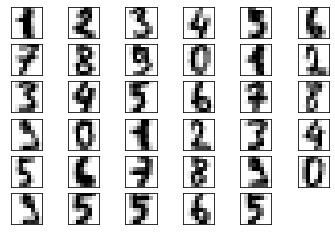

In [284]:
# Visualización de las imagenes
figure(1)
for i in range(1, 36):
  ax = subplot(6,6,i)
  ax.xaxis.set_major_locator(NullLocator()) 
  ax.yaxis.set_major_locator(NullLocator())
  imshow(digits.images[i], cmap = cm.gray_r) 

Utilizaremos el modelo logistic regression para obtener una métrica sin utilizas la reducción de componentes mediante manifold learning.

In [335]:
# División de los datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Escalando los datos
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

# modelo logistic regresion
clf = LogisticRegression(random_state = 42)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.9648148148148148

Vemos que el modelo ya sin hacer reducción de componentes es bastante bueno, veremos que sucede al reducir componentes vía manifold learning.

* Manifold Learning, IsoMap

In [286]:
from sklearn.manifold import Isomap

In [287]:
# Usaremos Grid search con cross validation para obtener el número de vecinos y el número de componentes óptimo
best_score = 0
for n in range(1, 65): # componentes
  for i in [2, 3, 5, 7]: # vecinos
    # Entrenamos el algoritmo de manifold learning
    manifold = Isomap(n_neighbors = i, n_components = n)
    X_train_transform = manifold.fit_transform(X_train)

    # Entrenamos logistic regression
    clf = LogisticRegression(random_state = 42)
    # Obtenemos scores mediante cross validations
    scores = cross_val_score(clf, X_train_transform, y_train, cv = 5, scoring = 'accuracy')
    score = np.mean(scores)

    if score > best_score:
            best_score = score
            best_parameters = {'n_components': n, 'n_neighbors': i}

print("Mejor score {:.2f}".format(best_score))
print("Mejores parámetros {}".format(best_parameters))

Mejor score 0.98
Mejores parámetros {'n_components': 62, 'n_neighbors': 7}


In [288]:
# Reducimos la dimensionalidad mediante el algoritmo con los mejores parametros
manifold = Isomap(**best_parameters)
X_train_transform = manifold.fit_transform(X_train)
X_test_transform = manifold.transform(X_test)

# Creamos el modelo de clasificación con componentes reducidas
clf = LogisticRegression(random_state = 42)
clf.fit(X_train_transform, y_train)
accuracy_score(y_test, clf.predict(X_test_transform))

0.9740740740740741

* Manifold Learning, Locally Linear Embeding


In [289]:
from sklearn.manifold import LocallyLinearEmbedding

In [290]:
# Usaremos Grid search con cross validation para obtener el número de vecinos y el número de componentes óptimo
best_score = 0

for n in range(1, 65): # componentes
  for i in [2, 3, 5, 7]: # vecinos
    # Entrenamos el algoritmo de manifold learning
    manifold = LocallyLinearEmbedding(n_neighbors = i, n_components = n, eigen_solver = 'dense')
    X_train_transform = manifold.fit_transform(X_train)

    # Entrenamos logistic regression
    clf = LogisticRegression(random_state = 42)
    # Obtenemos scores mediante cross validations
    scores = cross_val_score(clf, X_train_transform, y_train, cv = 5, scoring = 'accuracy')
    score = np.mean(scores)

    if score > best_score:
            best_score = score
            best_parameters = {'n_components': n, 'n_neighbors': i}

print("Mejor score {:.2f}".format(best_score))
print("Mejores parámetros {}".format(best_parameters))



Mejor score 0.98
Mejores parámetros {'n_components': 56, 'n_neighbors': 5}


In [291]:
# Reducimos la dimensionalidad mediante el algoritmo con los mejores parametros
manifold = LocallyLinearEmbedding(**best_parameters)
X_train_transform = manifold.fit_transform(X_train)
X_test_transform = manifold.transform(X_test)
# Creamos el modelo de clasificación con componentes reducidas
clf = LogisticRegression(random_state = 42)
clf.fit(X_train_transform, y_train)
accuracy_score(y_test, clf.predict(X_test_transform))

0.9740740740740741

En este caso vemos un desempeño similar en ambos modelos, sin embargo el algoritmo Locally Linear Embedding redujo la dimensión mucho más que Isomap. Usaremos este para dar algunas predicciones.

<Figure size 432x288 with 0 Axes>

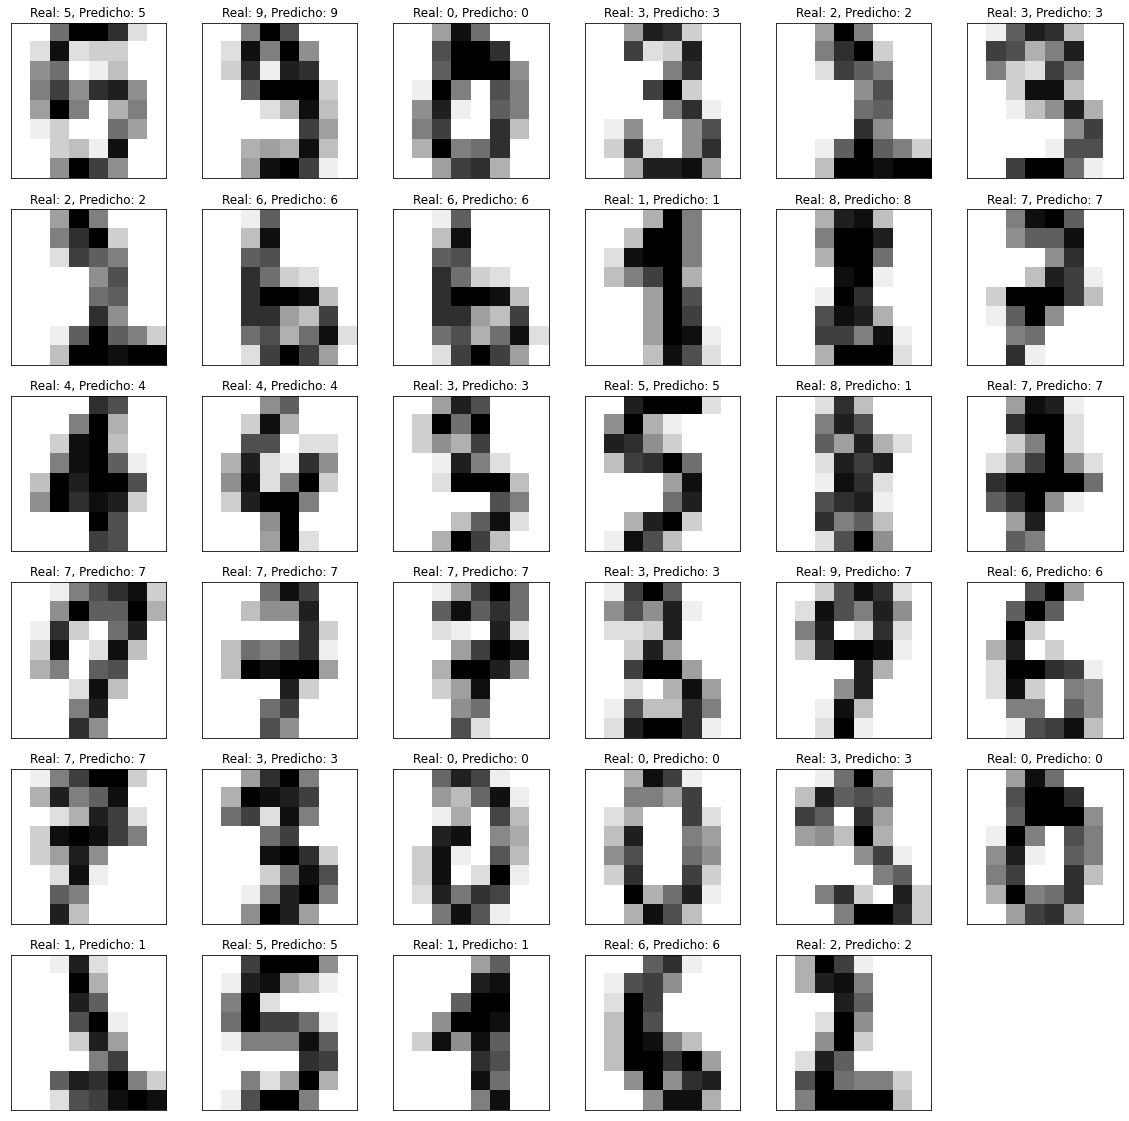

In [329]:
# Visualización de una muestra delconjunto de pruebas y las predicciones hechas
figure(1)
plt.figure(figsize = (20, 20))
for i in range(1, 36):
  ax = subplot(6, 6, i)
  indice_aleatorio = random.randint(1, len(y_test))
  ax.xaxis.set_major_locator(NullLocator()) 
  ax.yaxis.set_major_locator(NullLocator())
  imshow(X_test.reshape(540, 8, 8)[indice_aleatorio], cmap = cm.gray_r) 
  plt.title('Real: {}, Predicho: {}'.format( y_test[indice_aleatorio], clf.predict(X_test_transform)[:len(y_test)][indice_aleatorio]) )

EStos algoritmos resultan bastate interesantes, sin embargo vemos que para ambos algoritmos la información importante para las predicciones se encuentra en un gran número de componentes. Si embargo si se puede observar una diferencia entre ambos algoritmos. El primero requirió de practicamente todas las variables, mientras que el segundo redujo el número de variables, considerablemente. Además las predicciones fueron con un gran accuracy, ambos aumentaron esta métrica respecto a la obtenida sin hacer la reducción de componentes.